# Machine learning: Classification
## Part 2. Random forests
## Lecture objectives

1. Learn about the train-test split
2. Learn how to estimate and interpet a random forests model
3. Understand different ways to assess the predictive accuracy of a model

We'll continue with our example of ADUs in Los Angeles.

First, let's load in the pandas DataFrame that we saved at the end of the previous video lecture.

In [ ]:
import pandas as pd
joinedDf = pd.read_pickle('joined_permits.pandas')

# check it looks OK
joinedDf.head()

## Train-test split
In almost any prediction problem, we want to split the data into a "training sample" and a "testing sample". Assuming you have a large enough sample, this helps to evaluate the performance of your machine learning model. Essentially, you are assessing how well the model performs against new data that it has not seen before.

`scikit-learn` has built in functions to split the data. Note that this chooses a random sample. If you want to replicate your analysis, the `random_state` argument can do that. This works the same as a "seed" in other statistical software. It doesn't matter which seed (or random state) you choose, as long as it's the same each time.

In [ ]:
from sklearn.model_selection import train_test_split
train_test_split?

At this point, we also need to choose our variables. Our `y` variable is whether there is an ADU or not: `hasADU`.

For our `x` (predictor) variables, let's start with a few: `['SQFTmain1', 'Roll_LandValue', 'Roll_ImpValue']`.

We also need to drop Null values. Some `pandas` and `numpy` functions do this automatically, but the `scikit-learn` functions normally require us to drop the Null values ourselves.

In [ ]:
xvars = ['SQFTmain1', 'Roll_LandValue', 'Roll_ImpValue']
yvar = 'hasADU'

# create a dataframe with no NaNs
df_to_fit = joinedDf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# check we have a reasonable split
print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

If you rerun the above block of code, you should get exactly the same sample.

But if you change `random_state` (or omit that argument), you'll get a different random sample.

In [ ]:
X_train.head()

## Random Forests
Now we are ready to do some machine learning!

Random forests are based on the idea of a decision tree. At the crudest level, imagine a classifier that predicts `hasADU=True` if the lot is residential and larger than 5,000sf, and `hasADU=False` otherwise. (The exact threshold such as 5,000sf is estimated from the data.)

Here's the example from the Reades et al. article about urban gentrification.

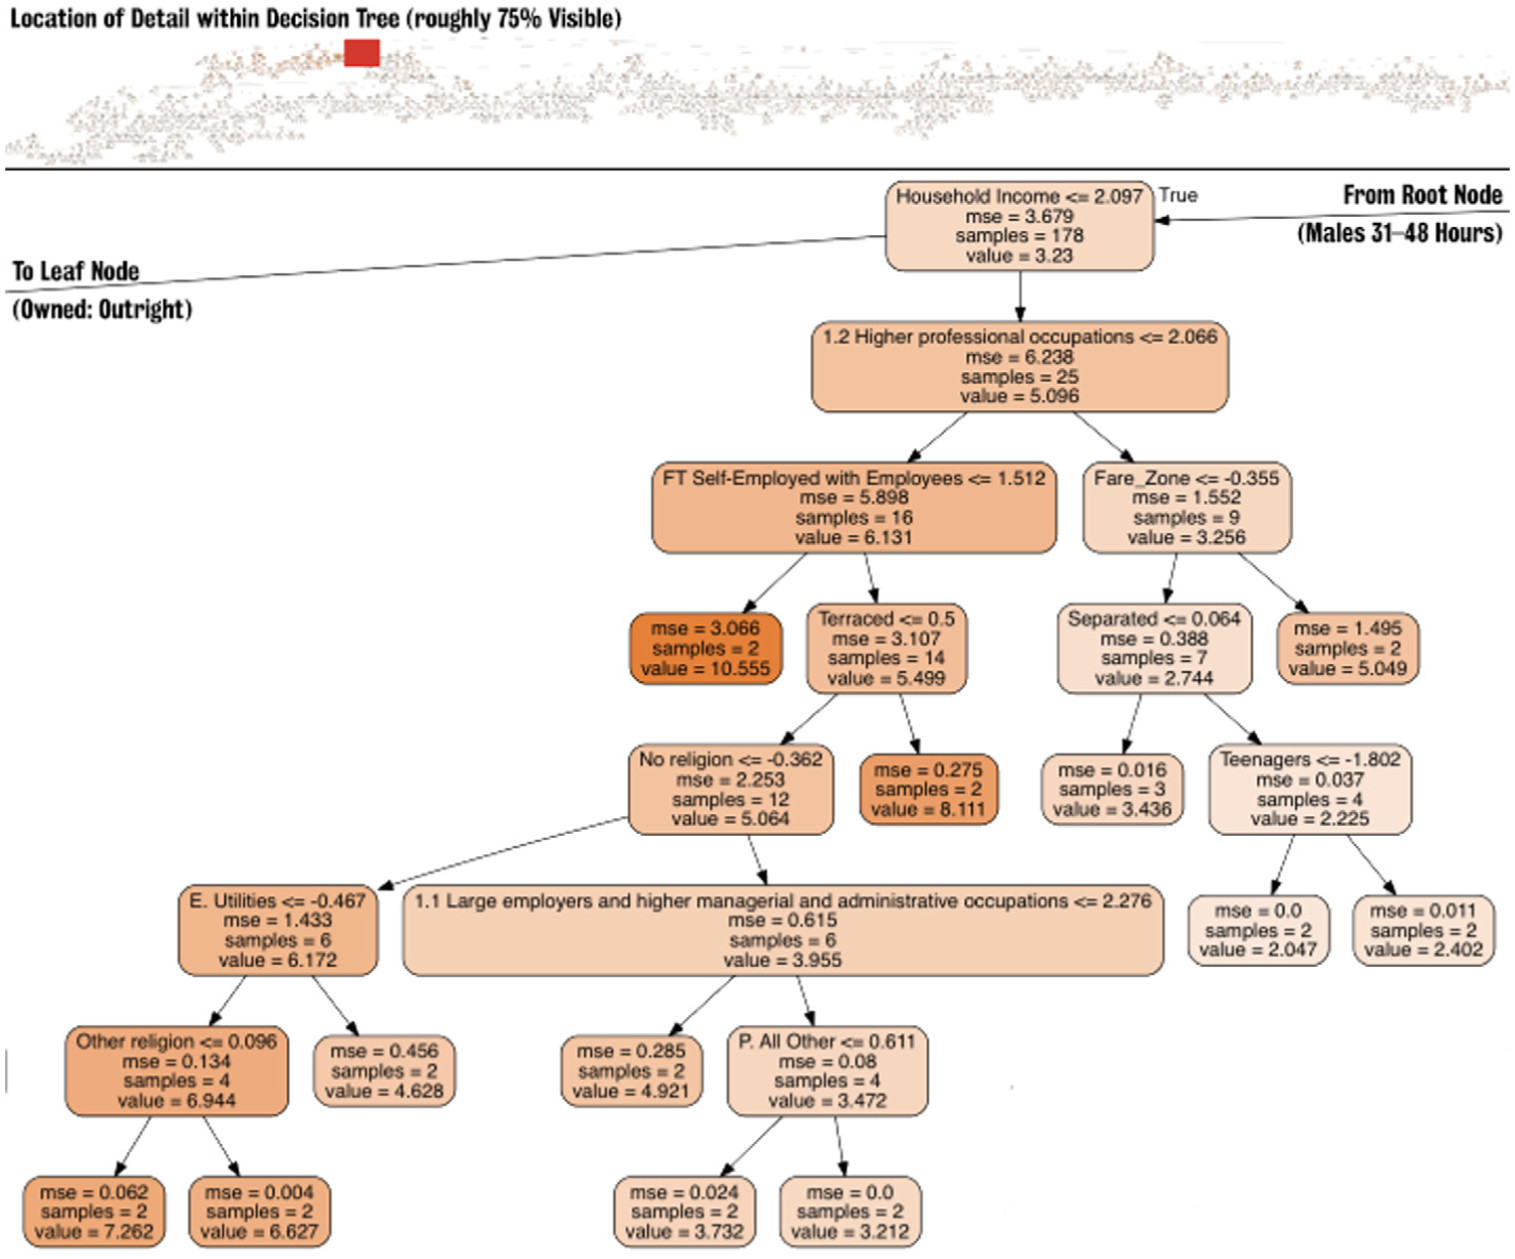

Such a deterministic tree is unlikely to do a great job in prediction. Enter random forests, which are a collection of decision trees. Each tree is trained on a subsample of the data. Then the predictions are combined, rather like the "wisdom of crowds." Formally, this process is called *ensemble learning*.

[For a more in-depth explanation, see this article by Neil Liberman.](https://towardsdatascience.com/decision-trees-and-random-forests-df0c3123f991)

Random forests are implemented in `scikit-learn`. An important parameter is the `n_estimators` (i.e., the number of trees). Up to a point, more trees will mean better predictions. But more trees also mean that the code will run more slowly. A general rule: get it working with a small number of trees.

Even with 50 trees, you might hear your computer fan run a bit faster.

In [ ]:
from sklearn.ensemble import RandomForestClassifier # note there is also a RandomForestRegressor

# initialize the random forest classifer object
rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

# now fit the model
rf.fit(X_train, y_train)

Once we've estimated the model on the *training* dataset, we can apply it to predict whether an ADU will be built on an "unseen" parcel. In other words, we apply the predictions to the *test* dataset.

That gives us an array of predictions.

In [ ]:
y_pred = rf.predict(X_test)
y_pred

Let's verify that we have one prediction for each row of the data frame.

In [ ]:
print(len(X_test), len(y_pred))

How can we assess the performance of this model? One quick check is to look at the means (i.e., the percentage `True`) in each sample.

In [ ]:
print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(
    y_pred.mean(), y_test.mean()))

So that doesn't look too good. We can also look more formally at the predictive accuracy.

`scikit-learn` has several useful functions here:
* The [*confusion matrix*](https://en.wikipedia.org/wiki/Confusion_matrix) gives the number of observations that fall into each predicted and actual category (e.g is True and predicted to be True - a "true positive")
* The [*accuracy score*](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score) gives the fraction of accurate predictions. A high score is no guarantee of a good model. Suppose you want to predict whether a person will be struck by lightening tomorrow. Then just predict "No" for everyone. Accurate, but not useful!
* The [*classification report*](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report) reports key metrics for each category (in this case, `True` and `False`. *Precision* gives the fraction of true positives compared to the number of predicted positives (TP / (TP + FP) - basically, how many of our positive predictions are correct. *Recall* gives the fraction of true positives compared to the number of actual positives (TP / (TP + FN) - basically, what proportion of the positives did we correctly predict.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
confusion_matrix?

In [ ]:
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

In [ ]:
print(classification_report(y_test, y_pred))

We can also plot the confusion matrix. Note the colorbar shows the number of observations.

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

That was a useful proof-of-concept. But our predictions were pretty dire. We might be able to fix this by:
* Adding more variables
* Adding more trees
* Adjusting other hyperparameters (we won't discuss that here)

Let's throw all the variables in our dataset into the model. This would be bad practice for a hypothesis-testing oriented statistical model. But with prediction, we can throw in the kitchen sink, and rely on the model to separate out what is useful.

Note that string variables need to be encoded into dummy variables before we can use them. For example, our `UseType` and `UseDescription` variables need to be split into a series of True or False variables such as `Residential`, `Commercial`, etc.

The [`get_dummies()` function](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) is useful for this. It converts a string into a series of binary True or False (i.e., dummy) variables.

In [ ]:
joinedDf.UseType.unique()

In [ ]:
joinedDf.UseDescription.unique()

In [ ]:
dummies1 = pd.get_dummies(joinedDf.UseType, prefix='usetype_')  # creates a dataframe of dummies
dummies2 = pd.get_dummies(joinedDf.UseDescription, prefix='usedesc_')
print(joinedDf.UseType.head())
dummies1.head()

Notice that the index generated by `get_dummies()` is the same as our original data frame (it's the APN). So it's simple to join the dummies back to the original dataframe.

In [ ]:
# join back to the original dataframe
joinedDf = joinedDf.join(dummies1).join(dummies2) 
joinedDf.head()

Now, let's estimate a random forests classifier using these dummy variables, plus many other columns that might be useful predictors.

This is exactly the same code as above, just with an expanded set of X variables. 

In [ ]:
xvars = (dummies1.columns.tolist() + dummies2.columns.tolist() + 
            ['YearBuilt1', 'Units1', 'Bedrooms1', 'Bathrooms1', 'SQFTmain1', 'Roll_LandValue', 
             'Roll_ImpValue', 'Roll_LandBaseYear', 'Roll_ImpBaseYear', 'CENTER_LAT', 'CENTER_LON' ])
yvar = 'hasADU'
df_to_fit = joinedDf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

rf = RandomForestClassifier(n_estimators = 100, random_state = 1, n_jobs=-1) # n_jobs uses all your computer's cores

# now fit the model
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

A bit better. In particular, we do a much better job in getting the true positives (see our precision score). 

It's still not great. But this is not surprising: ADU construction will depend on many factors that are outside our dataset: lot shape, the ability of the owners to afford an ADU, and their personal circumstances (e.g. having an elderly family member). Bringing in census data and other predictors might help.

But even if the predictions are not always accurate, the predicted *probabilities* can be informative. We could even map them to indicate where ADUs are likely to be built. 

We can access the probabilities from the `rf` object. Note it gives us a matrix: the first column is the probability of `False`, and the second is the probability of `True`.

In [ ]:
rf.predict_proba(X_test)

It's easy to turn an array like this into a pandas DataFrame.

In [ ]:
# create a dataframe
predictions = pd.DataFrame(rf.predict_proba(X_test), 
                           columns = ['pred_noADU', 'pred_ADU'])
predictions.head()

Let's join our original test data back to these predictions. 

One wrinkle: we just have an integer index on `predictions`. Does this match `X_test`? 

In [ ]:
X_test.head()

No, that has the original `APN` index. Fortunately, `reset_index()` will change the index to a sequential integer index.

In [ ]:
predictions= predictions.join(X_test.reset_index())
predictions.head()

Now, let's map these predictions. First, we need to create a geometry column.

In [ ]:
import geopandas as gpd
predictions = gpd.GeoDataFrame(predictions, 
                    geometry = gpd.points_from_xy(
                        predictions.CENTER_LON, 
                        predictions.CENTER_LAT, crs='EPSG:4326'))

In [ ]:
import contextily as ctx
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
predictions.to_crs('EPSG:3857').plot('pred_ADU', markersize=0.001, ax=ax)
ctx.add_basemap(ax=ax)
ax.set_xticks([])
ax.set_yticks([])

Actually, this map says more about where parcels overlap rather than the presence of an ADU. There are a couple of strategies that we might use to avoid this:
* Don't plot parcels with less than a certain probability of having an ADU
* Use a different colormap (the `cmap` argument)
* Use a smaller marker size (to avoid some overlap) (the `markersize` argument)
* Scale the colormap so that it tops out at a lower value (the `vmax` argument)

Let's try the first approach.

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
predictions[predictions.pred_ADU>0.01].to_crs('EPSG:3857').plot('pred_ADU', cmap='Purples', markersize=0.001, 
                                     vmax=0.02, ax=ax, legend=True)
ctx.add_basemap(ax=ax, alpha = 0.3)
ax.set_xticks([])
ax.set_yticks([])

Hmm. Maybe changing the marker size is a better way to go than a color.

We can do this by scaling the column that we plot.

In [ ]:
import contextily as ctx
import matplotlib.pyplot as plt

predictions['pred_ADU_scaled'] = predictions.pred_ADU*0.1
fig, ax = plt.subplots(figsize=(10,10))
predictions[predictions.pred_ADU>0.01].to_crs('EPSG:3857').plot(cmap='Purples', 
                                     markersize='pred_ADU_scaled', 
                                     ax=ax, legend=True)
ctx.add_basemap(ax=ax, alpha=0.4)
ax.set_xticks([])
ax.set_yticks([])

It's still not clear how to distinguish areas with lots of parcels from areas with few parcels but a high propensity to have an ADU. Any ideas? 

We'll leave the mapping here, but my inclination would be to aggregate to a grid or to census block groups, in order to make the propensity to have an ADU a bit clearer.

### Feature importances
In a regression model, the size of the coefficient is a good guide to how important a factor is in determining the outcome.

In a random forests setting, the equivalent concept is *feature importance*. It is often measured through "mean decrease in impurity" (MDI). The meaning of MDI is beyond our scope here, but you can interpret feature importance as "how much does a variable improve our predictions." 

The importances are accessed from the `feature_importances_` property of the `rf` object. [The `scikit-learn` docs provide easy-to-implement examples](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html), which we'll follow here.


In [ ]:
# code from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

import numpy as np
importances = rf.feature_importances_

# convert to a series, and give the index labels from our X_train dataframe
forest_importances = pd.Series(importances, index=X_train.columns)

# get the standard deviations to be able to plot the error bars
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# plot importances
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

So we see that only a few variables are driving the results.

The bar chart is pretty bad. We have a few options:
* Make a larger plot with horizontal bars, so that the text is easier to read
* Only plot the most important features
* Use an interactive tool where you can hover over the bar. The `plotly` and `mplcursors` libraries are two options here.

Let's try the first option.

In [ ]:
# use seaborn rather than matplotlib
import seaborn as sns

# sort the importances in descending order
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(4,15))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

We can see that the value of the land and the improvements on the lot, the location (latitude and longitude), size, and year built are the most predictive factors. 

### Unpacking the decision trees
Finally, let's take a closer look at the decision trees. Remember, the random forests approach works by estimating an ensemble of trees, and then combining them to get the aggregate prediction.

Note that the previous model we estimated is too complex to plot, so let's make it simpler using the `max_depth` hyperparameter. That limits the number of levels of each decision tree.

How do we read this tree?
* The first line of each box is the decision criterion
* *Samples* gives the number of observations at each node on the tree
* *Values* gives the outcome (*y*) values, i.e. the number of parcels with and without an ADU

In [ ]:
# same as before, but with max_depth=4
rf = RandomForestClassifier(n_estimators = 100, random_state = 1, n_jobs=-1, max_depth=4) 
rf.fit(X_train, y_train)

# now we have 100 estimators (trees), so let's pick the first one to visualize
e = rf.estimators_[0]

from sklearn import tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(40,20))  
_ = tree.plot_tree(e, feature_names = X_train.columns, fontsize=15, ax = ax)

Not surprisingly, the first branch of the tree is whether the use is residential. (It's hard to have an ADU on a non-residential lot.) 

Let's look at another tree in our ensemble.

In [ ]:
e = rf.estimators_[1]

fig, ax = plt.subplots(figsize=(40,20))  
_ = tree.plot_tree(e, feature_names = X_train.columns, fontsize=15, ax = ax)

Let's pause here. The next video lecture will look at other types of machine learning models, particularly neural networks.

<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>Random forests are one of the most widely used machine learning models.</li>
  <li>Confusion matrices are an excellent way to assess predictive performance.</li>
    <li>Feature importance is a way of showing which variables matter in your model.</li>
  <li>We focused here on a binary outcome. But ML also works for continuous outcomes (e.g. air quality) and data with multiple categories (e.g. mode choice).</li>
</ul>
</div>